In [1419]:
import sys 
sys.path.append('../../')
import_path = '../export/'

In [1420]:
import pandas as pd
import seaborn as sns

def load_dataset(datasetname):
    df = pd.read_csv(datasetname)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df
def load_plain_and_perturbed_dataset(epsilon):
    dataset_name1 = import_path + 'plain.csv'
    dataset_name2 = import_path + 'perturbed_' + str(epsilon) + '.csv'
    dataset1 = load_dataset(dataset_name1)
    dataset2 = load_dataset(dataset_name2)
    return dataset1, dataset2

def compare_datasets(dataset1, dataset2, epsilon):
    sns.scatterplot(data=dataset1, x='X', y='Y', label='baseline')
    sns.scatterplot(data=dataset2, x='X', y='Y', label='epsilon: {eps}'.format(eps=epsilon))

def load_and_compare(epsilon):
    dataset1, dataset2 = load_plain_and_perturbed_dataset(epsilon)
    compare_datasets(dataset1, dataset2, epsilon)

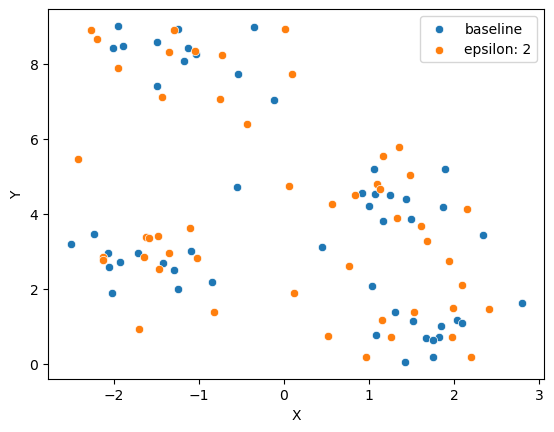

In [1421]:
load_and_compare(2)

## Euclidean distance

In [1422]:
epsilons = [0.05, 0.5, 1, 2, 3, 6]
export_path = import_path + 'privacy_scores'

In [1423]:
import numpy as np


def Euclidean_Dist(df1, df2, cols=['X','Y']):
    return np.average(np.linalg.norm(df1[cols] - df2[cols],
                   axis=1))
def calculate_avg_distance_between_datasets(epsilon):
    plain_df, perturbed_df = load_plain_and_perturbed_dataset(epsilon)
    return Euclidean_Dist(plain_df, perturbed_df)

def calculate_avg_distance_for_epsilons(epsilons):
    dict = {'epsilon': [], 'distance': []}
    for epsilon in epsilons:
        distance = calculate_avg_distance_between_datasets(epsilon)
        dict['epsilon'].append(epsilon)
        dict['distance'].append(distance)
    pd.DataFrame(dict).to_csv(export_path + '/report.csv')


In [1424]:
calculate_avg_distance_for_epsilons(epsilons)

### Plot

In [1425]:
distances_per_epsilon = load_dataset(export_path + '/report.csv')
distances_per_epsilon.head()

,epsilon,distance
0,0.05,3.690706
1,0.50,2.474732
2,1.00,1.679564
3,2.00,0.918258
4,3.00,0.692669


<AxesSubplot:title={'center':'Average euclidean distance (privacy) of the perturbed dataset in comparison to the non-perturbed (plain) dataset'}, xlabel='Privacy budget ($\\epsilon$)', ylabel='Average euclidean distance'>

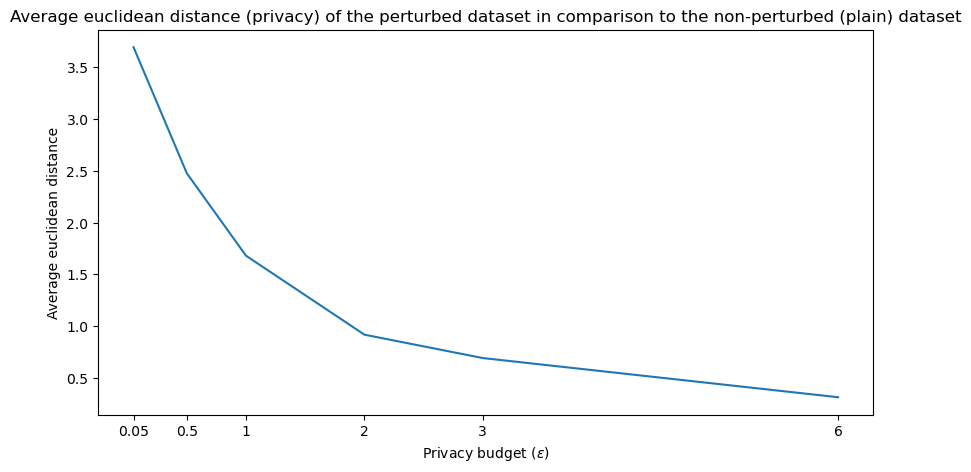

In [1426]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Average euclidean distance (privacy) of the perturbed dataset in comparison to the non-perturbed (plain) dataset')
ax.set_ylabel('Average euclidean distance')
ax.set_xlabel('Privacy budget ($\epsilon$)')
ax.set_xticks(epsilons, labels=epsilons)
sns.lineplot(data=distances_per_epsilon, x='epsilon', y='distance', ax=ax, markers='True')

## Other

In [1427]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from Helpers import twod_laplace
X, y_true = make_blobs(n_samples=1000, centers=4, n_features=2,
                       cluster_std=0.60, random_state=0)

_, _, Z = twod_laplace.generate_truncated_laplace_noise(X, 0.5)
Z_pd = pd.DataFrame(Z, columns=['X', 'Y'])
X_pd = pd.DataFrame(X, columns=['X', 'Y'])
create_labels = KMeans(init='random', n_clusters=4)
create_labels.fit(X_pd)
Z_pd['target'] = create_labels.labels_
X_pd['target'] = create_labels.labels_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff16f80f70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffff16f80f70>
Traceback 

In [1428]:
## train classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def train_model(X_train, y_train):
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    # test data for attack model

    return clf

In [1429]:
train_ratio = 0.25
shadow_ratio = 0.75
dataset = train_test_split(Z_pd.iloc[:, 0:2], Z_pd['target'], test_size=shadow_ratio)

# train is now 75% of the entire data set
x_target, x_shadow, y_target, y_shadow = dataset
# test is now 10% of the initial data set
# validation is now 15% of the initial data set
target_train_size = len(x_target) // 2
x_target_train = x_target[:target_train_size]
y_target_train = y_target[:target_train_size]
x_target_test = x_target[target_train_size:]
y_target_test = y_target[target_train_size:]

print(x_target.shape, x_shadow.shape)

(250, 2) (750, 2)


In [1430]:
# dataset = train_test_split(X, Y, test_size=0.50)
classifier = train_model(x_target_train, y_target_train)

In [1431]:
#shokri_mi_outputs = shokri_membership_inference(args, pred_y, membership, classes)
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier

art_classifier = ScikitlearnRandomForestClassifier(classifier)
print('Base model accuracy:', classifier.score(x_target_test, y_target_test))


Base model accuracy: 0.456


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [1432]:
x_shadow_np = X_pd.iloc[x_shadow.index, 0:2].to_numpy()
y_shadow_np = X_pd.iloc[x_shadow.index, 2].to_numpy()

In [1433]:
from art.utils import to_categorical
from art.attacks.inference.membership_inference import ShadowModels

shadow_models = ShadowModels(art_classifier, num_shadow_models=3)
shadow_dataset = shadow_models.generate_shadow_dataset(x_shadow_np, to_categorical(y_shadow_np, 4))


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [1434]:
(member_x, member_y, member_predictions), (nonmember_x, nonmember_y, nonmember_predictions) = shadow_dataset
print([sm.model.score(x_target_test, y_target_test) for sm in shadow_models.get_shadow_models()])

[0.56, 0.528, 0.52]


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [1435]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")
attack.fit(member_x, member_y, nonmember_x, nonmember_y, member_predictions, nonmember_predictions)

In [1436]:
member_infer = attack.infer(x_target_train, y_target_train)
nonmember_infer = attack.infer(x_target_test, y_target_test)
member_acc = np.sum(member_infer) / len(x_target_train)
nonmember_acc = 1 - np.sum(nonmember_infer) / len(x_target_test)
acc = (member_acc * len(x_target_train) + nonmember_acc * len(x_target_test)) / (len(x_target_train) + len(x_target_test))
print('Attack Member Acc:', member_acc)
print('Attack Non-Member Acc:', nonmember_acc)
print('Attack Accuracy:', acc)

Attack Member Acc: 0.104
Attack Non-Member Acc: 0.984
Attack Accuracy: 0.544


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1437]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1
    
    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

In [1438]:
print(calc_precision_recall(np.concatenate((member_infer, nonmember_infer)), 
                            np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))))

(0.8666666666666667, 0.104)


In [1439]:
predicted_y = np.concatenate((member_infer, nonmember_infer))
actual_y = np.concatenate((np.ones(len(member_infer)), np.zeros(len(nonmember_infer))))

In [1440]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(actual_y, predicted_y, pos_label=1)


In [1441]:
print(tpr[1], fpr[1])

0.104 0.016


In [1442]:
attack_adv = tpr[1] - fpr[1]
attack_adv

0.088

Text(0, 0.5, 'Privacy Leakage')

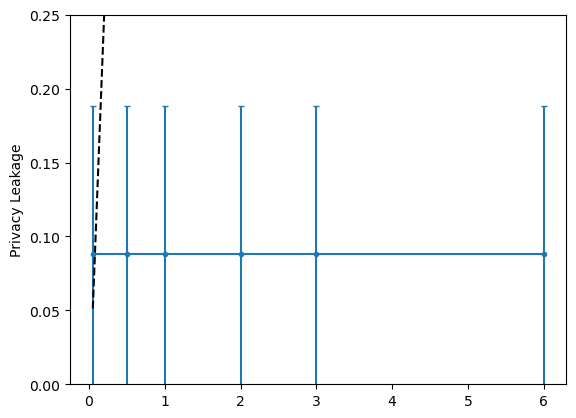

In [1443]:
def theoretical_limit(epsilons):
	return [np.exp(eps) - 1 for eps in epsilons]

def pretty_position(X, Y, pos):
	return ((X[pos] + X[pos+1]) / 2, (Y[pos] + Y[pos+1]) / 2)



bottom, top = plt.ylim()
plt.errorbar(epsilons, theoretical_limit(epsilons), color='black', fmt='--', capsize=2, label='Theoretical Limit')
plt.errorbar(epsilons, [attack_adv, attack_adv,attack_adv,attack_adv,attack_adv, attack_adv], yerr=0.1, fmt='.-', capsize=2)
plt.ylim(bottom, 0.25)
plt.annotate("$\epsilon$-DP Bound", pretty_position(epsilons, theoretical_limit(epsilons), 4), textcoords="offset points", xytext=(5,0), ha='left')
plt.yticks(np.arange(0, 0.26, step=0.05))
plt.ylabel('Privacy Leakage')

In [1444]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import numpy as np

from art.utils import load_nursery


target_train_size = len(x_target) // 2
x_target_train = x_target[:target_train_size]
y_target_train = y_target[:target_train_size]
x_target_test = x_target[target_train_size:]
y_target_test = y_target[target_train_size:]

x_target_train.shape

(125, 2)

In [1445]:
model = RandomForestClassifier()
model.fit(x_target_train, y_target_train)

art_classifier = ScikitlearnRandomForestClassifier(model)

print('Base model accuracy:', model.score(x_target_test, y_target_test))

Base model accuracy: 0.432


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [1446]:
shadow_models = ShadowModels(art_classifier, num_shadow_models=3)

shadow_dataset = shadow_models.generate_shadow_dataset(x_shadow, to_categorical(y_shadow, 4))
(member_x, member_y, member_predictions), (nonmember_x, nonmember_y, nonmember_predictions) = shadow_dataset

# Shadow models' accuracy


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


KeyError: "None of [Int64Index([740, 419, 407, 241, 210, 479, 101, 595, 394, 452,\n            ...\n            601, 582, 328, 237, 518, 117, 318,  60, 585, 282],\n           dtype='int64', length=750)] are in the [columns]"

In [ ]:
print([sm.model.score(x_target_test, y_target_test) for sm in shadow_models.get_shadow_models()])

[0.9635802469135802, 0.9592592592592593, 0.9604938271604938]


In [ ]:

attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")
attack.fit(member_x, member_y, nonmember_x, nonmember_y, member_predictions, nonmember_predictions)

In [ ]:
member_infer = attack.infer(x_target_train, y_target_train)
nonmember_infer = attack.infer(x_target_test, y_target_test)
member_acc = np.sum(member_infer) / len(x_target_train)
nonmember_acc = 1 - np.sum(nonmember_infer) / len(x_target_test)
acc = (member_acc * len(x_target_train) + nonmember_acc * len(x_target_test)) / (len(x_target_train) + len(x_target_test))
print('Attack Member Acc:', member_acc)
print('Attack Non-Member Acc:', nonmember_acc)
print('Attack Accuracy:', acc)

Attack Member Acc: 0.4891908585546634
Attack Non-Member Acc: 0.865432098765432
Attack Accuracy: 0.6773695585057117
